In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tensorflow import keras
import seaborn as sns
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import Input, Dense, Conv2D, Activation, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization, Flatten, Reshape, Conv2DTranspose, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.utils import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

np.random.seed(72)
tf.random.set_seed(72)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5



In [3]:
def evaluate_(model, generator_test):
    model.evaluate(generator_test)
    
    y_pred = model.predict(generator_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = generator_test.classes
    class_labels = list(generator_test.class_indices.keys())

    print(classification_report(y_true, y_pred_classes))
    cm = confusion_matrix(y_true, y_pred_classes)
    
    # Plotting the confusion matrix
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.show()

In [4]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_(model, generator_test):
    model.evaluate(generator_test)
    
    y_pred = model.predict(generator_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = generator_test.classes
    class_labels = list(generator_test.class_indices.keys())

    print(classification_report(y_true, y_pred_classes))
    cm = confusion_matrix(y_true, y_pred_classes)
    
    # Plotting the confusion matrix
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix')
    
    # ROC curve
    plt.subplot(1, 2, 2)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(len(class_labels)):
        fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    for i in range(len(class_labels)):
        plt.plot(fpr[i], tpr[i], label=f'{class_labels[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")

    plt.tight_layout()
    plt.show()

# Call the function with your model and test generator


In [5]:
train_dir = r"/kaggle/input/mango-leaf/mango-prepo/train"
test_dir = r"/kaggle/input/mango-leaf/mango-prepo/test"
datagen_train = ImageDataGenerator(rescale=1./255,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  horizontal_flip=True,
                                  vertical_flip=False)


datagen_test = ImageDataGenerator(rescale=1./255)


batch_size = 16
generator_train = datagen_train.flow_from_directory(directory=train_dir,
                                                    target_size=(112, 112),
                                                    batch_size=batch_size,
                                                    shuffle=True)

generator_test = datagen_test.flow_from_directory(directory=test_dir,
                                                  target_size=(112, 112),
                                                  batch_size=batch_size,
                                                  shuffle=False)
# Calculate class weights
labels = generator_train.classes
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(labels), y=labels)
class_weights = dict(zip(np.unique(labels), class_weights))
print(class_weights)

Found 13307 images belonging to 26 classes.
Found 1684 images belonging to 26 classes.
{0: 1.0640492563569486, 1: 1.0662660256410257, 2: 1.0662660256410257, 3: 1.0402595372107568, 4: 1.2273565762774397, 5: 1.0381494772975504, 6: 1.053102247546692, 7: 1.2795192307692307, 8: 1.0487862547288778, 9: 1.053102247546692, 10: 0.6486789509603198, 11: 1.0662660256410257, 12: 1.4623076923076923, 13: 0.8809082483781279, 14: 0.7571119708693673, 15: 1.0466414975617429, 16: 1.7527660695468914, 17: 0.5415954415954416, 18: 1.0662660256410257, 19: 0.9042538733351454, 20: 0.789826685660019, 21: 1.5462468045549616, 22: 1.0256667180514876, 23: 1.8085077466702908, 24: 1.0445054945054946, 25: 0.7259683578832515}


In [6]:
!pip install keras_cv_attention_models 

In [7]:
from keras_cv_attention_models import coatnet
mm = coatnet.CoAtNet0(input_shape=(112, 112, 3), pretrained="imagenet")

93670048/93670048 [==============================] - 0s 0us/step
>>>> Load pretrained from: /root/.keras/models/coatnet0_160_imagenet.h5
>>>> Reload mismatched weights: 160 -> (112, 112)
>>>> Reload layer: stack_3_block_1_mhsa_pos_emb
>>>> Reload layer: stack_3_block_2_mhsa_pos_emb
>>>> Reload layer: stack_3_block_3_mhsa_pos_emb
>>>> Reload layer: stack_3_block_4_mhsa_pos_emb
>>>> Reload layer: stack_3_block_5_mhsa_pos_emb
>>>> Reload layer: stack_4_block_1_mhsa_pos_emb
>>>> Reload layer: stack_4_block_2_mhsa_pos_emb


In [10]:
from keras_cv_attention_models import coatnet
mm = coatnet.CoAtNet0(input_shape=(112, 112, 3), pretrained="imagenet")

>>>> Load pretrained from: /root/.keras/models/coatnet0_160_imagenet.h5
>>>> Reload mismatched weights: 160 -> (112, 112)
>>>> Reload layer: stack_3_block_1_mhsa_pos_emb
>>>> Reload layer: stack_3_block_2_mhsa_pos_emb
>>>> Reload layer: stack_3_block_3_mhsa_pos_emb
>>>> Reload layer: stack_3_block_4_mhsa_pos_emb
>>>> Reload layer: stack_3_block_5_mhsa_pos_emb
>>>> Reload layer: stack_4_block_1_mhsa_pos_emb
>>>> Reload layer: stack_4_block_2_mhsa_pos_emb


In [ ]:
from keras_cv_attention_models import res_mlp
# mm = res_mlp.ResMLP12()

In [9]:
mm = res_mlp.ResMLP12(input_shape=(112, 112, 3), pretrained="imagenet")

NameError: name 'res_mlp' is not defined

In [ ]:
from keras_cv_attention_models import wave_mlp
mm = wave_mlp.WaveMLP_T(input_shape=(112, 112, 3), pretrained="imagenet")

In [ ]:
from keras_cv_attention_models import mobilevit
mm = mobilevit.MobileViTBasePatch16(input_shape=(112, 112, 3))
mm2 = mobilevit.MobileViTBasePatch16(input_shape=(112, 112, 3))


In [ ]:
# mm.summary()

In [ ]:
from keras_cv_attention_models import swin_transformer_v2

In [ ]:
mm2 = swin_transformer_v2.SwinTransformerV2Tiny_window8(input_shape=(112, 112, 3))

In [ ]:
# mm2.summary()

In [ ]:
"""
transfer_layer = mm.get_layer('avg_pool')
conv_model = Model(inputs=mm.input, outputs=transfer_layer.output)
"""

In [ ]:
"""
#for layer in conv_model.layers:
#    layer.trainable = False
    
# Start a new Keras Sequential model.
new_model = Sequential()

# Add the convolutional part of the VGG16 model from above.
new_model.add(conv_model)


# Add the final layer for the actual classification.
new_model.add(Dense(2, activation='softmax'))
"""

In [ ]:
from keras_cv_attention_models import beit
mm2 = beit.BeitBasePatch16(input_shape=(112, 112, 3))

In [12]:
mm_last_layer = mm.get_layer('avg_pool').output
#out = Dense(256, activation='relu', name='dense_1')(mm_last_layer)
#out = Dense(11, activation='softmax', name='prediction1')(out)
mm_custom = Model(mm.input, mm_last_layer)

In [ ]:
mm2_last_layer = mm2.get_layer('out_ln').output
#out2 = Dense(256, activation='relu', name='dense_1')(mm2_last_layer)
#out2 = Dense(11, activation='softmax', name='prediction1')(out2)
mm2_custom = Model(mm2.input, mm2_last_layer)

In [ ]:
# Define a custom linear attention layer
class LinearAttentionLayer(keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super(LinearAttentionLayer, self).__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        self.W_q = self.add_weight(shape=(input_shape[-1], self.units), initializer='uniform', trainable=True)
        self.W_k = self.add_weight(shape=(input_shape[-1], self.units), initializer='uniform', trainable=True)
        self.W_v = self.add_weight(shape=(input_shape[-1], self.units), initializer='uniform', trainable=True)

    def call(self, inputs):
        Q = tf.matmul(inputs, self.W_q)
        K = tf.matmul(inputs, self.W_k)
        V = tf.matmul(inputs, self.W_v)

        attn_scores = tf.matmul(Q, K, transpose_b=True)
        attn_scores = tf.nn.softmax(attn_scores / tf.math.sqrt(tf.cast(self.units, tf.float32)), axis=-1)
        output = tf.matmul(attn_scores, V)

        return output

# ... Continue with your code ...

# Add the attention layer where needed in your model
num_classes = 2
avg_ensemble_model_last_layer = avg_ensemble_model.get_layer('average').output

# Add Linear Attention Layer here (for example, just before the output layer)
attention_output = LinearAttentionLayer(64)(avg_ensemble_model_last_layer)

output_layer = Dense(num_classes, activation='softmax', name='output_1')(attention_output)
final_model = Model(avg_ensemble_model.input, output_layer)

final_model.summary()

In [ ]:
from tensorflow.keras import layers
inputs = keras.Input(shape=(112,112,3))
outputs = layers.average([mm_custom(inputs), mm2_custom(inputs)])

avg_ensemble_model = keras.Model(inputs=inputs, outputs=outputs)
avg_ensemble_model.summary()

In [13]:
from tensorflow.keras import layers
inputs = keras.Input(shape=(112,112,3))
outputs = layers.average([mm_custom(inputs)])

avg_ensemble_model = keras.Model(inputs=inputs, outputs=outputs)
avg_ensemble_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 112, 112, 3)]     0         
                                                                 
 model (Functional)          (None, 768)               22487658  
                                                                 
 average (Average)           (None, 768)               0         
                                                                 
Total params: 22,487,658
Trainable params: 22,476,010
Non-trainable params: 11,648
_________________________________________________________________


In [14]:
num_classes = 26
avg_ensemble_model_last_layer = avg_ensemble_model.get_layer('average').output
output_layer = Dense(num_classes, activation='softmax', name='output_1')(avg_ensemble_model_last_layer)
final_model = Model(avg_ensemble_model.input, output_layer)

final_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 112, 112, 3)]     0         
                                                                 
 model (Functional)          (None, 768)               22487658  
                                                                 
 average (Average)           (None, 768)               0         
                                                                 
 output_1 (Dense)            (None, 26)                19994     
                                                                 
Total params: 22,507,652
Trainable params: 22,496,004
Non-trainable params: 11,648
_________________________________________________________________


In [15]:
optimizer = Adam(lr=1e-5)
loss = 'categorical_crossentropy'
# metrics = ['categorical_accuracy']
metrics = ['accuracy', 'categorical_accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 
           tf.keras.metrics.TruePositives(), tf.keras.metrics.TrueNegatives(), tf.keras.metrics.FalsePositives(), 
           tf.keras.metrics.FalseNegatives(), tfa.metrics.CohenKappa(num_classes = num_classes), 
           tfa.metrics.F1Score(num_classes = num_classes)]

final_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
import os

# Delete the existing HDF5 file if it exists
if os.path.exists('Best_DenseNet201.h5'):
    os.remove('Best_DenseNet201.h5')

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1,
    patience=9, mode="max", min_delta=0.0001, min_lr=0.00001, verbose=1)
checkpoint = ModelCheckpoint(filepath='Best_DenseNet201_v23.h5', save_best_only=True, monitor = 'val_accuracy', verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, restore_best_weights=True)

callbacks = [lr, checkpoint, early_stopping]

In [17]:
epochs = 30

steps_per_epoch = generator_train.n / batch_size
steps_test = generator_test.n / batch_size

history = final_model.fit_generator(generator=generator_train,
                                  epochs=epochs,
                                  steps_per_epoch=steps_per_epoch,
                                  validation_data=generator_test,
                                  validation_steps=steps_test,
                                   callbacks=callbacks, class_weight =class_weights)

/tmp/ipykernel_2299/2027776823.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = final_model.fit_generator(generator=generator_train,


Epoch 1/30
832/831 [==============================] - ETA: 0s - loss: 1.7249 - accuracy: 0.5562 - categorical_accuracy: 0.5562 - auc: 0.9209 - precision: 0.6935 - recall: 0.4825 - true_positives: 6420.0000 - true_negatives: 329838.0000 - false_positives: 2837.0000 - false_negatives: 6887.0000 - cohen_kappa: 0.5378 - f1_score: 0.5531
Epoch 1: val_accuracy improved from -inf to 0.56354, saving model to Best_DenseNet201_v23.h5
831/831 [==============================] - 277s 282ms/step - loss: 1.7249 - accuracy: 0.5562 - categorical_accuracy: 0.5562 - auc: 0.9209 - precision: 0.6935 - recall: 0.4825 - true_positives: 6420.0000 - true_negatives: 329838.0000 - false_positives: 2837.0000 - false_negatives: 6887.0000 - cohen_kappa: 0.5378 - f1_score: 0.5531 - val_loss: 1.9666 - val_accuracy: 0.5635 - val_categorical_accuracy: 0.5635 - val_auc: 0.9005 - val_precision: 0.6443 - val_recall: 0.5356 - val_true_positives: 902.0000 - val_true_negatives: 41602.0000 - val_false_positives: 498.0000 - va

106/106 [==============================] - 22s 195ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        61
           1       1.00      1.00      1.00        60
           2       0.63      0.70      0.66        60
           3       1.00      0.98      0.99        62
           4       0.98      1.00      0.99        53
           5       0.97      1.00      0.98        63
           6       1.00      1.00      1.00        62
           7       0.58      0.50      0.54        50
           8       1.00      1.00      1.00        62
           9       0.98      1.00      0.99        62
          10       1.00      0.99      0.99       100
          11       1.00      1.00      1.00        60
          12       1.00      1.00      1.00        45
          13       1.00      1.00      1.00        74
          14       1.00      0.99      0.99        86
          15       1.00      1.00      1.00        62
          16       1.00

/tmp/ipykernel_2299/2485669865.py:45: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


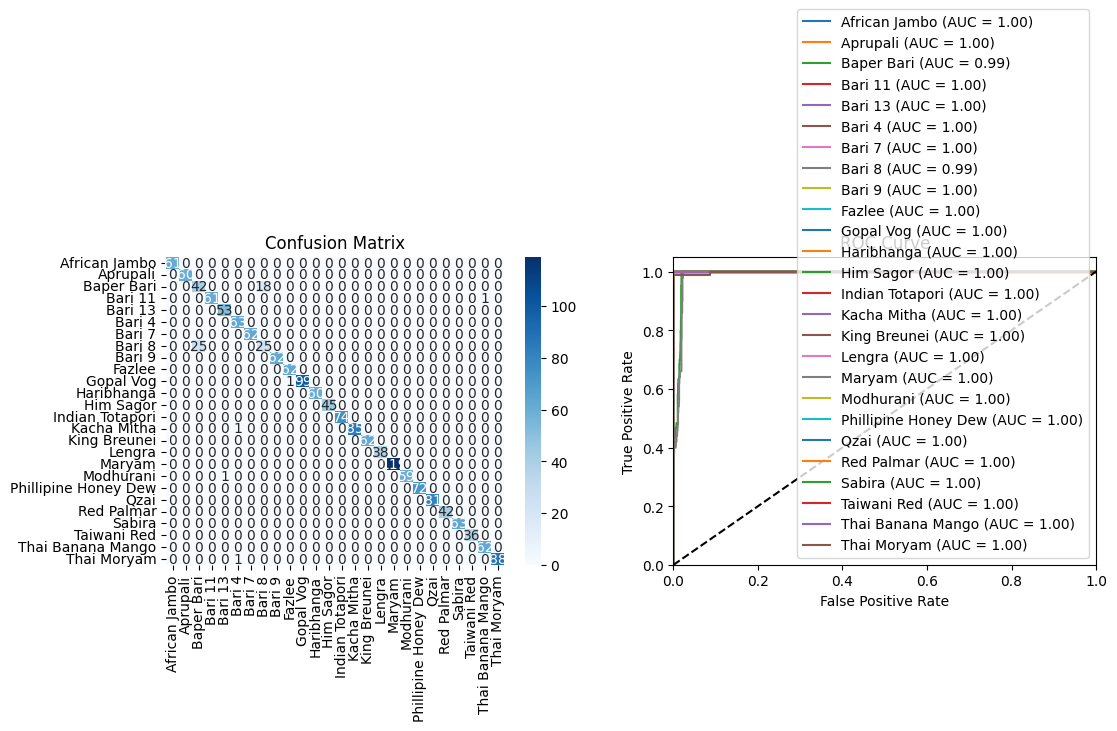

In [18]:
evaluate_(final_model, generator_test)

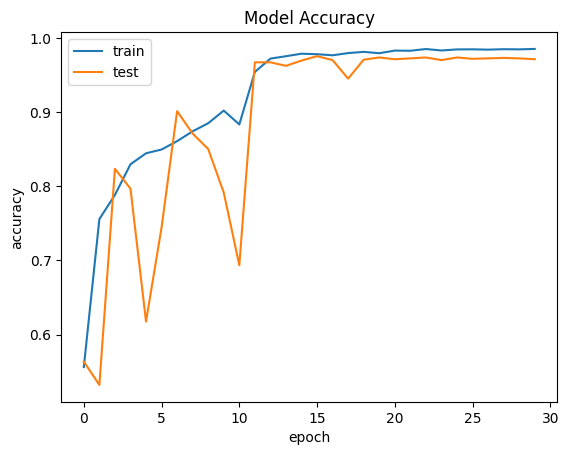

In [19]:
import matplotlib.pyplot as plt
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

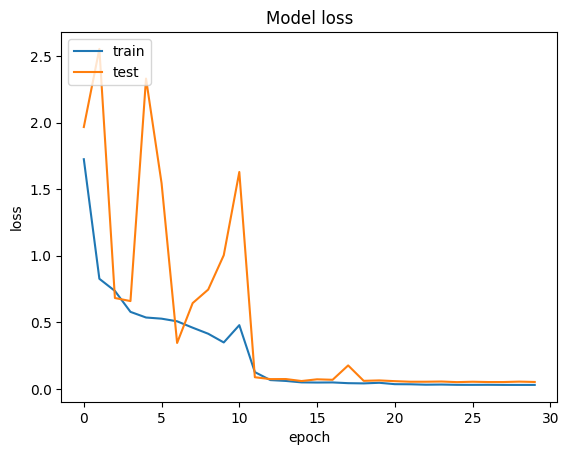

In [20]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
!pip install --upgrade scipy scikit-image


In [ ]:
image_size = 128
batch_size = 8

train_dir = r"/kaggle/input/mango-leaf/mango-prepo/train"
val_dir = r"/kaggle/input/mango-leaf/mango-prepo/val"
test_dir = r"/kaggle/input/mango-leaf/mango-prepo/test"


datagen_train = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1,
                                  horizontal_flip=True,  vertical_flip=False)
datagen_test = ImageDataGenerator(rescale=1./255)

train_generator = datagen_train.flow_from_directory(directory=train_dir, target_size=(image_size, image_size),
                                                    batch_size=batch_size, shuffle=True)
val_generator = datagen_test.flow_from_directory(directory=val_dir, target_size=(image_size, image_size),
                                                  batch_size=batch_size, shuffle=False)
test_generator = datagen_test.flow_from_directory(directory=test_dir, target_size=(image_size, image_size),
                                                  batch_size=batch_size, shuffle=False)

#Define the number of classes in your dataset
num_classes = train_generator.num_classes

In [ ]:
from tensorflow.keras.layers import Layer, Attention
import numpy as np

In [ ]:
class LinearAttention(Layer):
    def __init__(self, units):
        super(LinearAttention, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.W_q = self.add_weight(shape=(input_shape[-1], self.units), initializer='uniform', trainable=True)
        self.W_k = self.add_weight(shape=(input_shape[-1], self.units), initializer='uniform', trainable=True)
        self.W_v = self.add_weight(shape=(input_shape[-1], self.units), initializer='uniform', trainable=True)

    def call(self, inputs):
        Q = tf.matmul(inputs, self.W_q)
        K = tf.matmul(inputs, self.W_k)
        V = tf.matmul(inputs, self.W_v)

        attn_scores = tf.matmul(Q, K, transpose_b=True)
        attn_scores = tf.nn.softmax(attn_scores / tf.math.sqrt(tf.cast(self.units, tf.float32)), axis=-1)
        output = tf.matmul(attn_scores, V)

        return output


In [ ]:
# Define your model function with attention
def modelfunction_with_attention(base):
    x = base.output

    # Add Self-Attention Layer
    att_output = LinearAttention(128)(x)

    # Add more layers if needed
    x = tf.keras.layers.GlobalAveragePooling2D()(att_output)
    x = tf.keras.layers.Dropout(0.4)(x)
    predictions = tf.keras.layers.Dense(units=num_classes, activation='softmax', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.02, l2=0.02))(x)
    model = Model(inputs=base.input, outputs=predictions)
    return model

In [ ]:
def modelfunction(base):
    x = base.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    predictions = tf.keras.layers.Dense(units=num_classes, activation='softmax', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.02, l2=0.02))(x)
    model = Model(inputs=base.input, outputs=predictions)
    return model

def get_callbacks(weight):
    checkpoint = ModelCheckpoint(weight, monitor='val_loss', mode='min', save_best_only=True, verbose=1)
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=5, verbose=1, factor=0.2, min_lr=0.0002)
    callbacks = [checkpoint, learning_rate_reduction]
    return callbacks

def evaluate(model, generator_test):
    model.evaluate(generator_test)

    y_pred = model.predict(generator_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = generator_test.classes
    class_labels = list(generator_test.class_indices.keys())

    print(classification_report(y_true, y_pred_classes))
    cm = confusion_matrix(y_true, y_pred_classes)

    # Plotting the confusion matrix
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.show()

def model_training(base, weight, epochs):
    model = modelfunction(base)
    print("\n\n\n-------------------- Model Initialized --------------------")

    callbacks = get_callbacks(weight)
    metrics = ['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),
               tfa.metrics.CohenKappa(num_classes=num_classes), tfa.metrics.F1Score(num_classes=num_classes)]
    model.compile(tf.keras.optimizers.Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=metrics)

    history = model.fit(train_generator, steps_per_epoch=366 // batch_size,
                        validation_data=val_generator,  # Add this line
                        epochs=epochs, callbacks=callbacks)
    # Plotting accuracy and loss curves
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

    print("\n\n\n-------------------- Evaluation --------------------")
    evaluate(model, val_generator)

    return model


In [ ]:
# Create and train the model with attention
VGG19 = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_tensor=None, input_shape=None)
VGG19_model_with_attention = model_training(VGG19, 'VGG19_with_attention.h5', 10)

In [ ]:
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import random


In [ ]:
from lime import lime_image

In [ ]:
from skimage.segmentation import mark_boundaries